<a href="https://colab.research.google.com/github/TrzeciakPiotr2300/Uczenie_Maszynowe_2025/blob/main/HW08_automatic-gradient-training-loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK 3: **Add the repulsion penalty.**
--------------------------



To prevent points from clustering too closely, we introduce a repulsion penalty to the loss function. This term discourages points from being too close to one another by penalizing small pairwise distances. The updated loss function consists of two components: the original ellipse loss $L_{\text{ellipse}}$ and the repulsion penalty $L_{\text{repulsion}}$. The total loss is given by:

$$
L = L_{\text{ellipse}} + \lambda L_{\text{repulsion}}
$$

where $\lambda$ is a hyperparameter controlling the strength of the repulsion term. The repulsion loss is defined as:

$$
L_{\text{repulsion}} = \sum_{i \neq j} \frac{1}{(\| p_i - p_j \|^2 + \epsilon)}
$$

where $p_i$ and $p_j$ are the positions of the points, and $\epsilon$ is a small constant to prevent division by zero. By including this term, we ensure that points remain well-distributed along the ellipse while still minimizing $L_{\text{ellipse}}$. This results in a more evenly spaced set of points that better capture the desired elliptical shape.

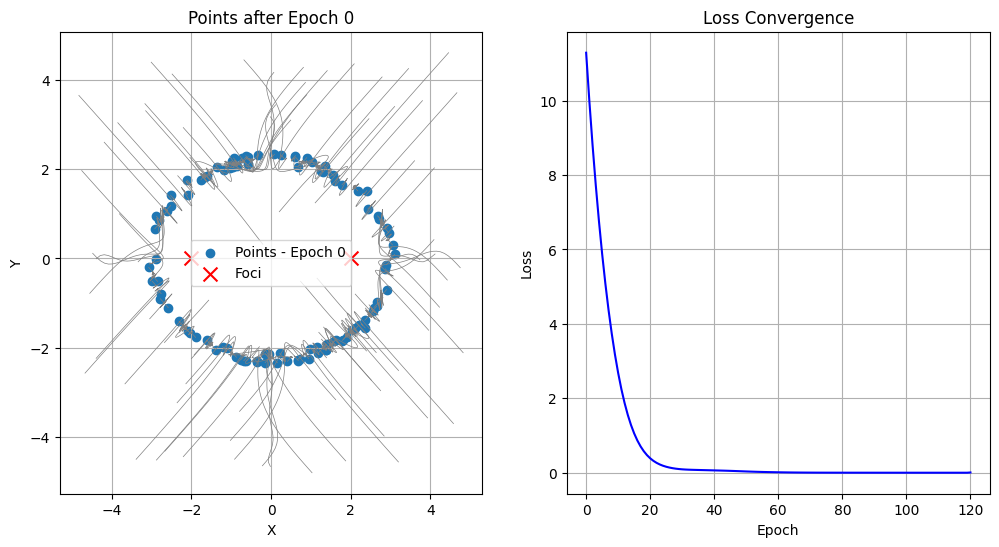

Epoch 0: Loss = 0.006433


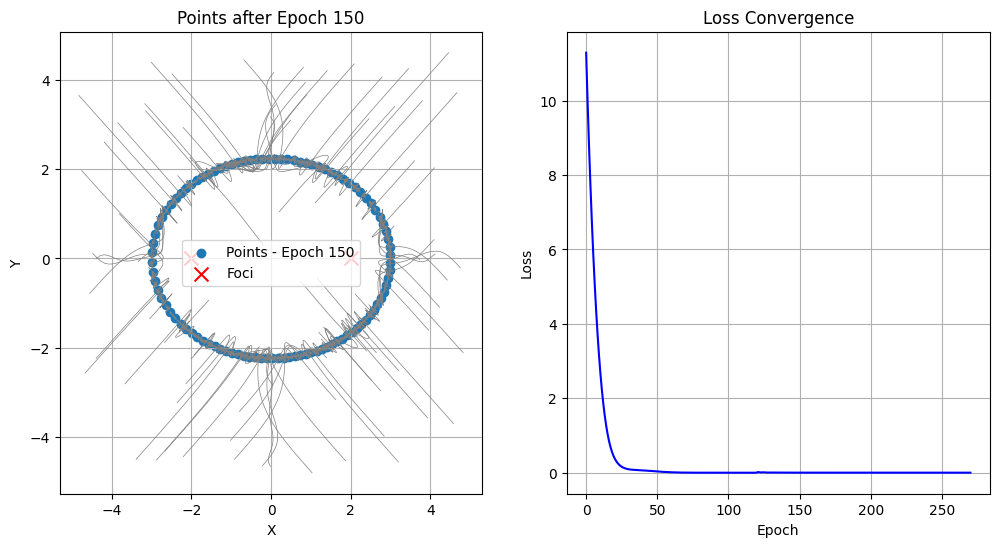

Epoch 150: Loss = 0.001234


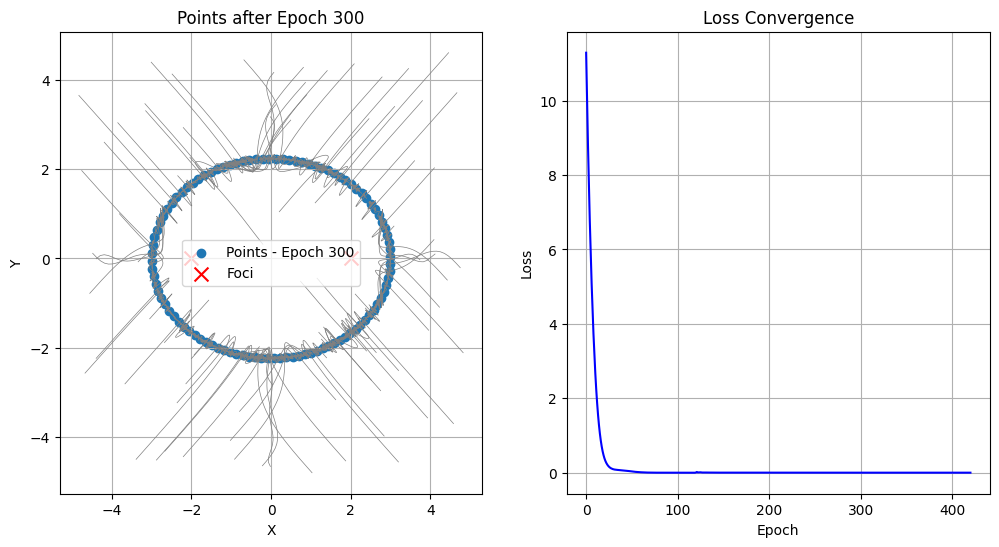

Epoch 300: Loss = 0.001200


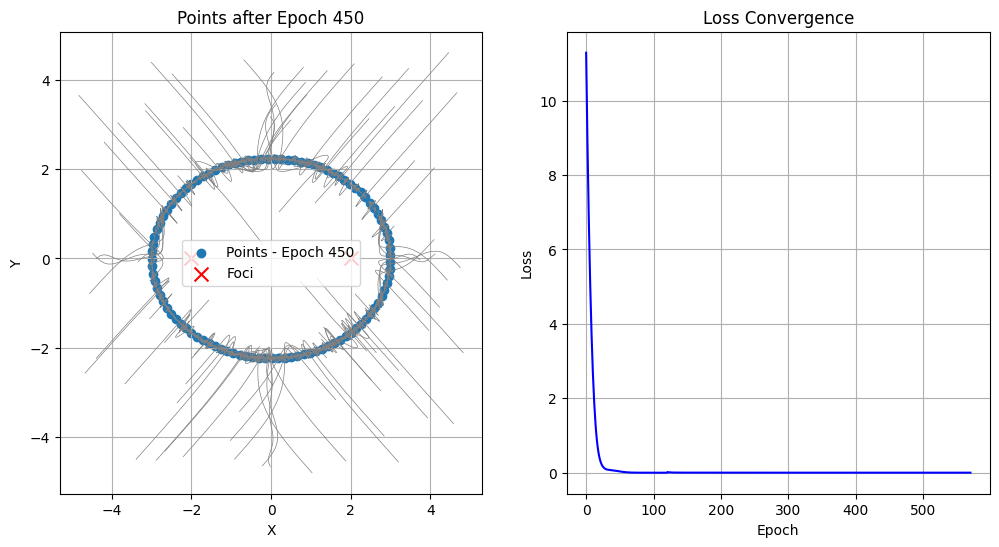

Epoch 450: Loss = 0.001193


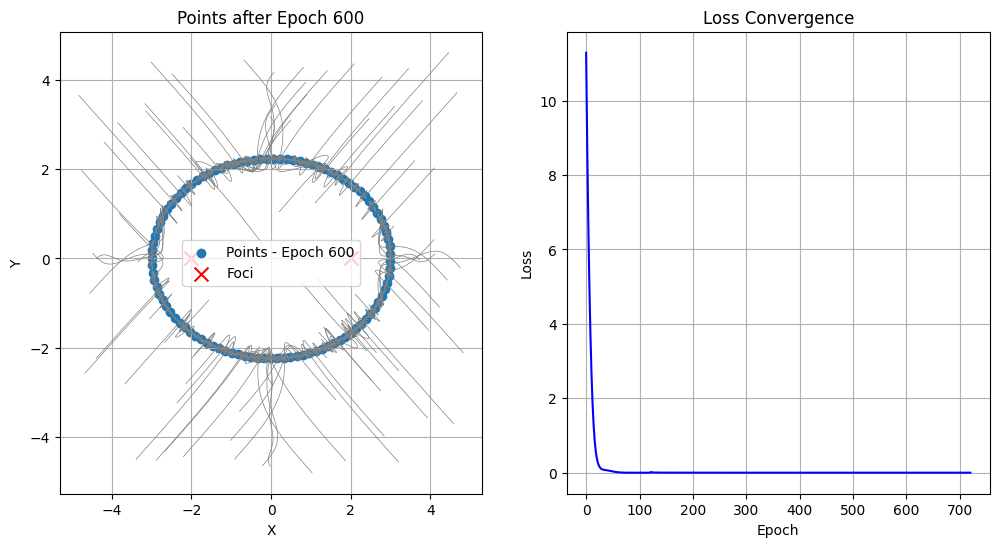

Epoch 600: Loss = 0.001190


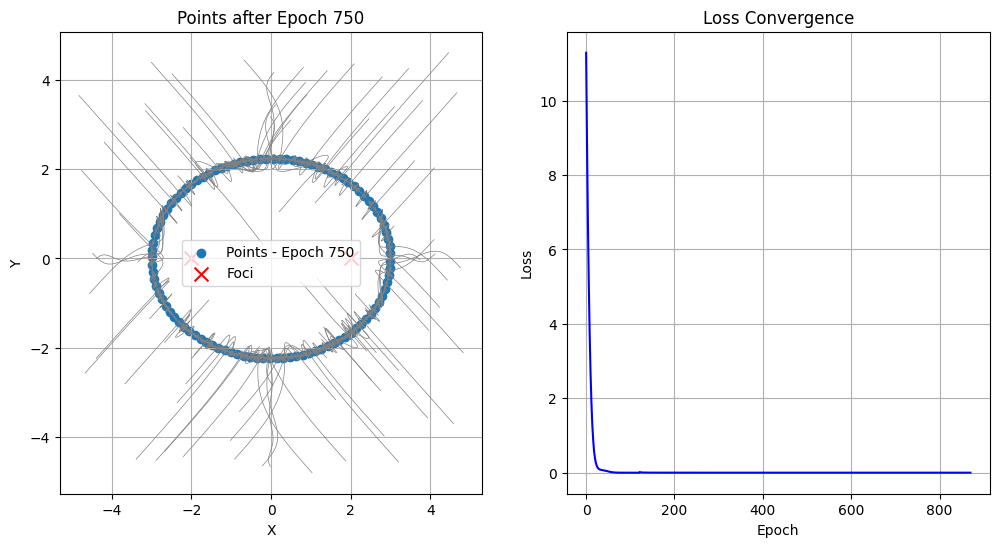

Epoch 750: Loss = 0.001189


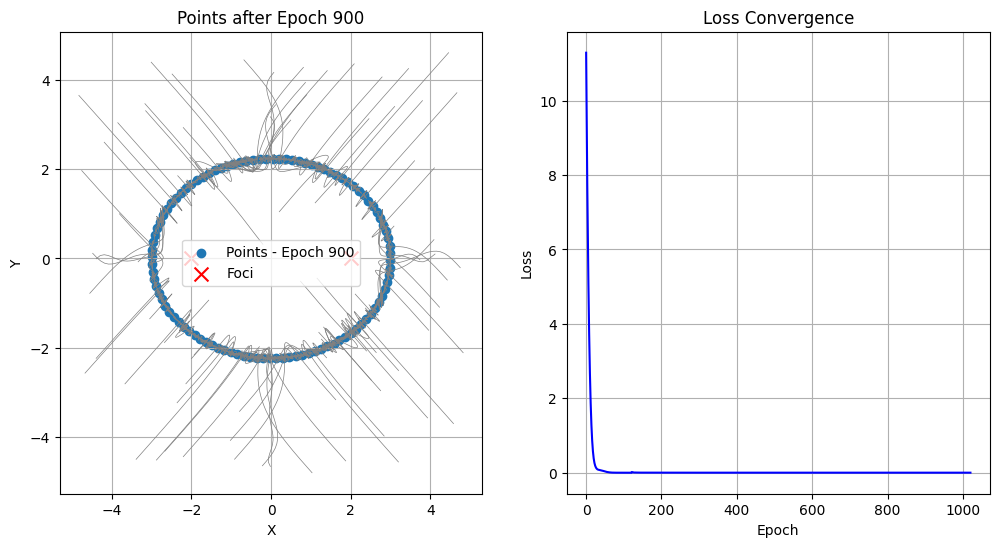

Epoch 900: Loss = 0.001199


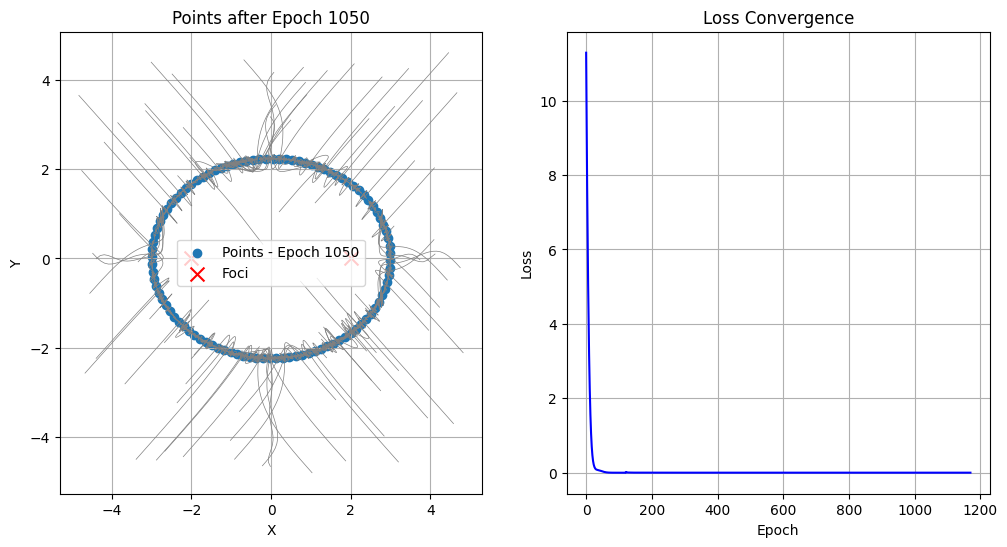

Epoch 1050: Loss = 0.001193


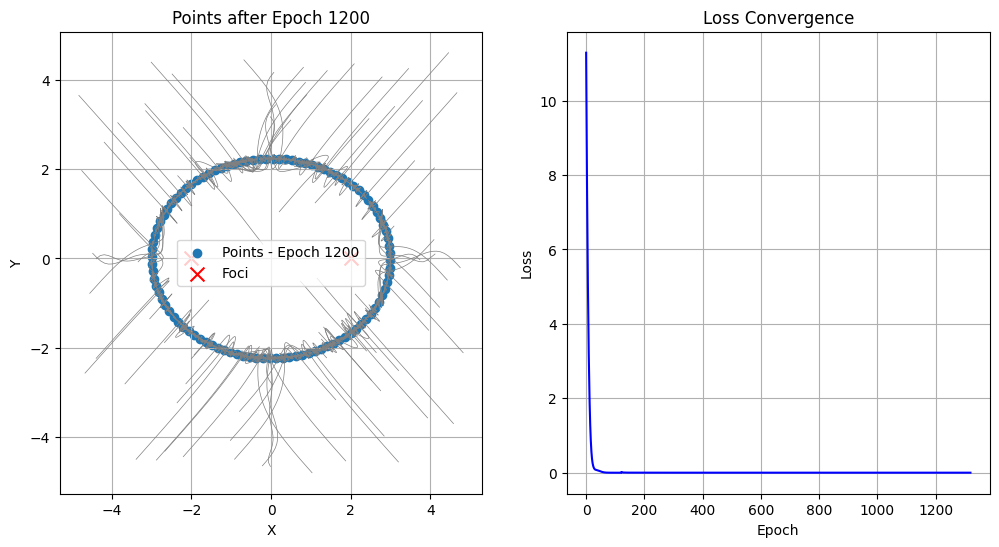

Epoch 1200: Loss = 0.001208


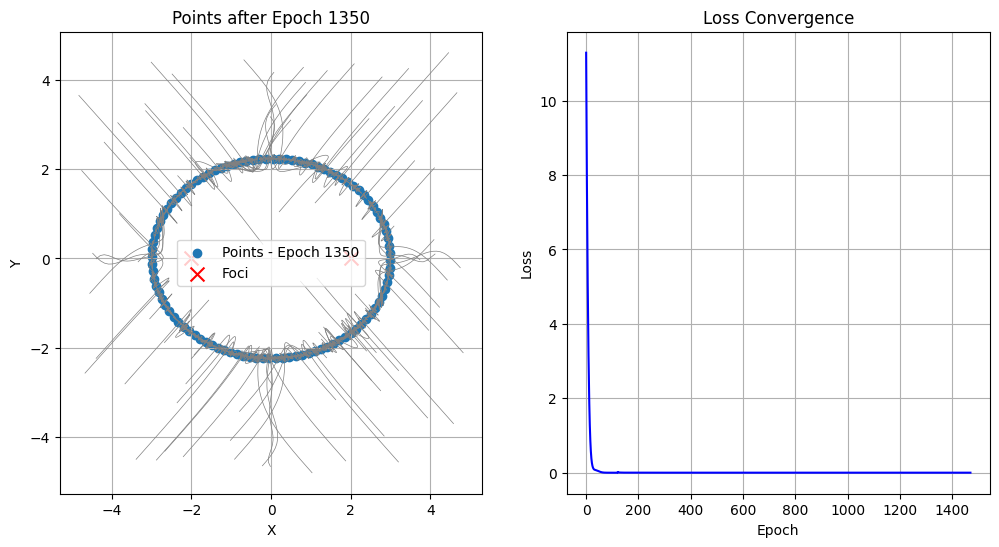

Epoch 1350: Loss = 0.001201


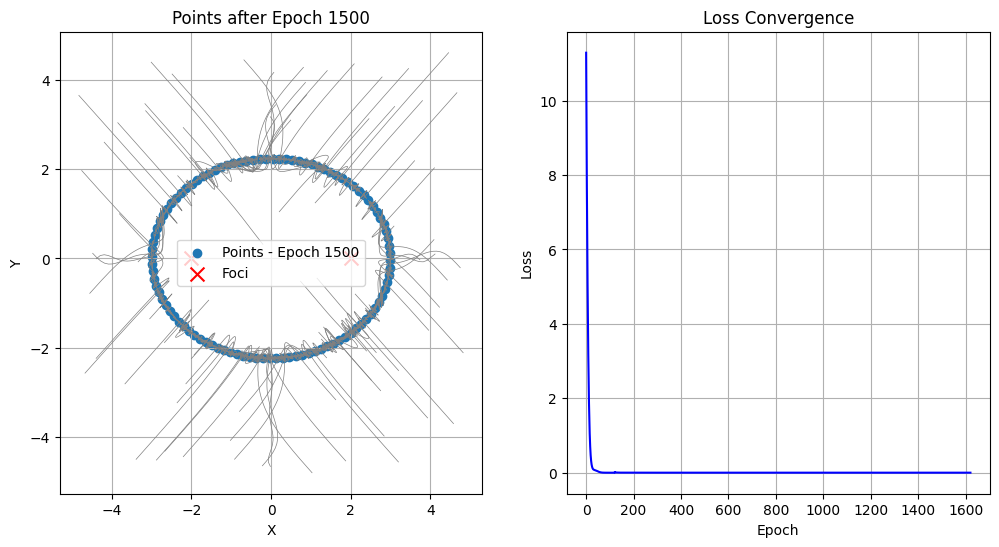

Epoch 1500: Loss = 0.001209


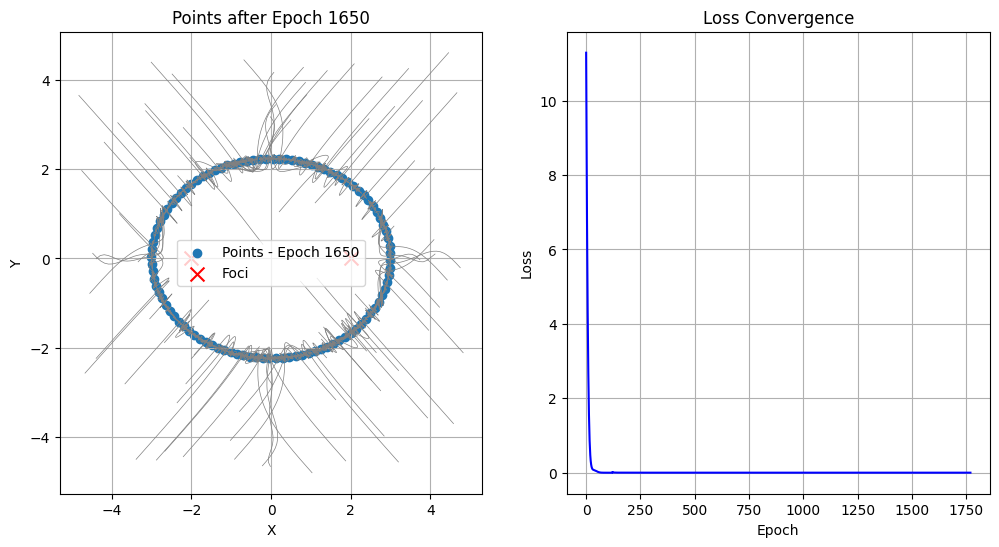

Epoch 1650: Loss = 0.001221


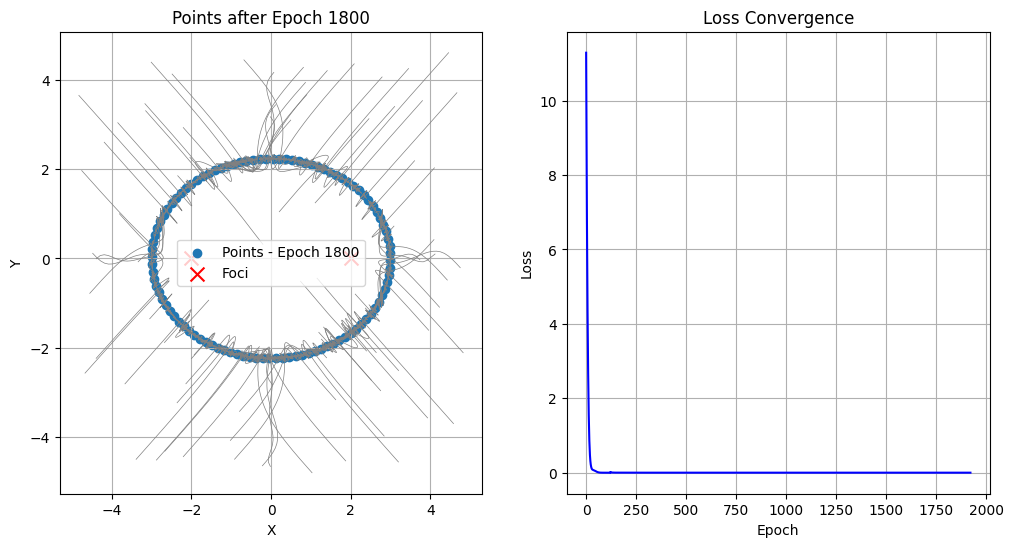

Epoch 1800: Loss = 0.001204


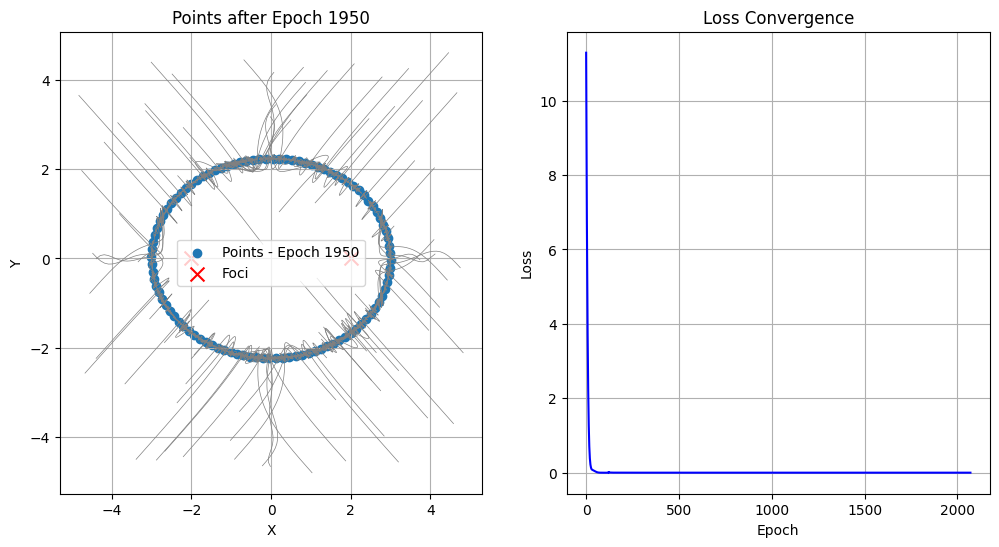

Epoch 1950: Loss = 0.001205


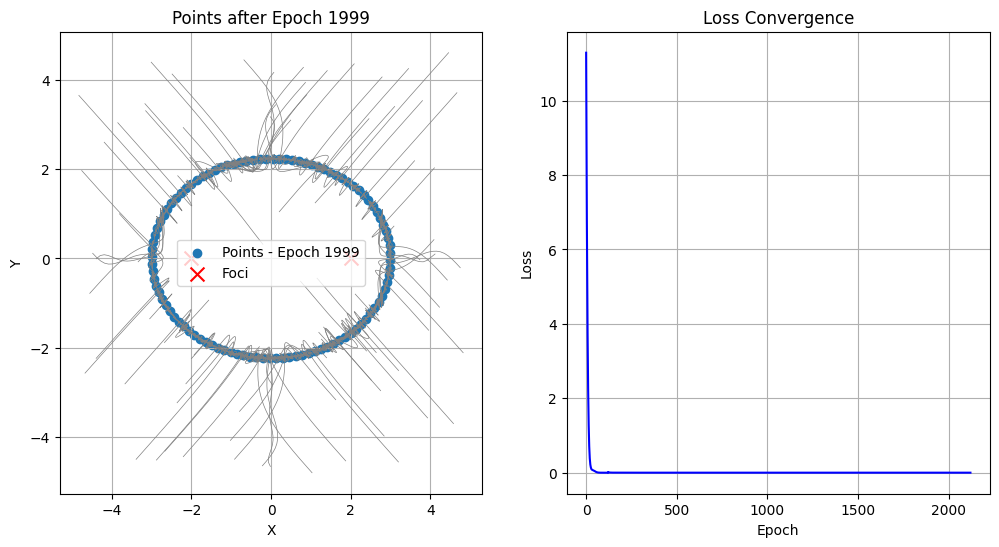

In [9]:
# Define optimizer
optimizer = torch.optim.Adam([points], lr=0.1)
lambda_repulsion = 0.001  # Weight for repulsion term



# Training loop
num_epochs = 2000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Compute distances to both foci
    dist1 = torch.norm(points - focus1, dim=1)
    dist2 = torch.norm(points - focus2, dim=1)

    # Compute loss for ellipse constraint
    loss_ellipse = torch.mean((dist1 + dist2 - constant_sum) ** 2)

    #------------------------------------
    # Compute repulsion loss
    #------------------------------------
    ''' double for loop, extremely nonefficient

    repulsion_loss = 0.0
    for i in range(num_points):
        for j in range(i + 1, num_points):
            distance = torch.norm(points[i] - points[j])
            repulsion_loss += 1.0 / (distance ** 2 + 1e-6)  # Avoid division by zero
    '''
    # TODO: Compute all pairwise distances in parallel
    diff = points.unsqueeze(1) - points.unsqueeze(0)  # shape (N, N, 2)
    distances = torch.norm(diff, dim=2)  # shape (N, N)

    # Avoid self-interactions (diagonal elements should be ignored)
    distances = distances + torch.eye(num_points, device=points.device) * 1e6  # Large value to effectively "remove" diagonal
                                                        # Shape: (N, N)
    # TODO: Compute inverse-square repulsion penalty by averaging the matrix or summing the matrix
    repulsion_matrix = 1.0 / (distances ** 2 + lambda_repulsion)

    # TODO: Normalize by number of pairs to keep scale consistent (if needed)
    repulsion_loss = torch.sum(repulsion_matrix) / (num_points * (num_points - 1))

    # Total loss
    loss = loss_ellipse + lambda_repulsion * repulsion_loss
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    # Store current positions for tracking movement
    for i in range(num_points):
        trajectories[i].append(points[i].detach().cpu().clone().numpy())

    # Plot results every 10th epoch
    if epoch % 150 == 0:
        plot_results(epoch, trajectories, loss_history)

    if epoch % 150 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")


#Final plot
plot_results(epoch, trajectories, loss_history)

# **Homework Assignment: Working with Other Loss Functions**

-------------------------------

During the class today, we reconstructed an **ellipse**. The ellipse was defined with two **foci** and $C$ (the sum of distances of the ellipse points from the foci).

To reconstruct the ellipse through optimization, we began with **$N$ points** scattered randomly in the 2D plane. Our goal was to adjust their positions so that they satisfy the elliptical constraint as closely as possible. We achieved this by minimizing the **error-related loss**, $L^{(2)}_{\text{ellipse}}$ which was defined in today's class with $\ell_2$ norm as:

$$
L^{(2)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} \epsilon_i^2
$$

where
$$
 \epsilon_i = d_{i1} + d_{i2} - C
$$
where $N$ is the number of points, and $d_{i1}, d_{i2}$ are their distances to the two foci.

In the homework assignment you will experiment with 3 other loss definitions based on some other possible norms.



1. $\ell_0$ norm resulting in
  $$
  L^{(0)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}(\epsilon_i \neq 0)
  $$
  - If you actually succeed to code this loss function, the question for you to answer in relation to $L^{(0)}_{\text{ellipse}}$ is why the training is not progressing with passing epochs.
  - If you actually fail to code this loss function, the question for you to answer is to explain the failure and reason out theoretically, why the training would not be progressing with passing epochs, anyway.

1. $\ell_1$ norm resulting in
  $$
  L^{(1)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} |\epsilon_i|
  $$
  The question for you to answer in relation to $L^{(1)}_{\text{ellipse}}$ is why the training loss doesn't converge, even after the ellipse has been fully drawn.

1. $\ell_\infty$ norm resulting in
  $$
  L^{(\infty)}_{\text{ellipse}} =  \max_{i} |\epsilon_i|
  $$
  The question for you to answer in relation to $L^{(\infty)}_{\text{ellipse}}$ is why the training takes so long and it doesn't converge in the end, either.

## **Points to Note**

1. Draw both the shape that the points draw as they move, and the loss value after each epoch, just as we did in class today.

2. Note, that the purpose of this excercise is not that you reconstruct a perfect ellipse, but rather that you give it a try, and even if you fail you should document and explain the failure, and answer a question related to a given loss definition.

3. You can also play around with the learning rate to try to improve convergence.

## **Task & Deliverables**
  
   - Document your experiments (python code and charts) and **write down your conclusions** into the Colab notebook.
   - It is not strictly required, but **if you make a movie showing the optimization progress it will be considered a strong point of your solution**
     - You can make a movie programmatically as we did in clustering class (our second class) with EM clustering,
     - or, you can save to disk the image files with epoch charts and use an external tool to bind them into a movie. Provide links to movie files in the README.
   - Place the Colab notebook  with the solution in your **GitHub repository** for this course.
   - In your repository’s **README**, add a **link** to the notebook (and any movies you created) and also include an **“Open in Colab”** badge at the top of the notebook so it can be launched directly from GitHub.

## Sample code

   You can use the sample code provided below:



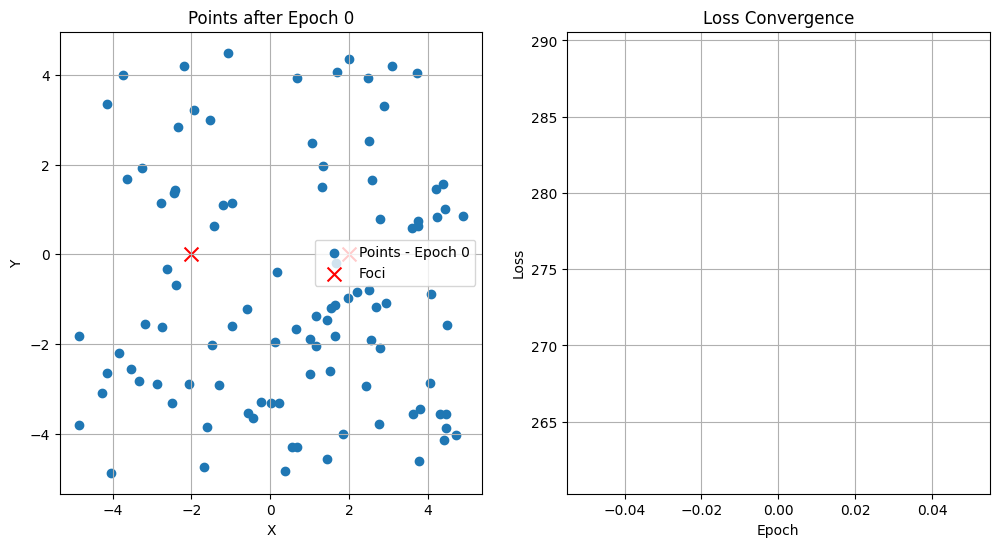

Epoch 0: Loss = 275.421173


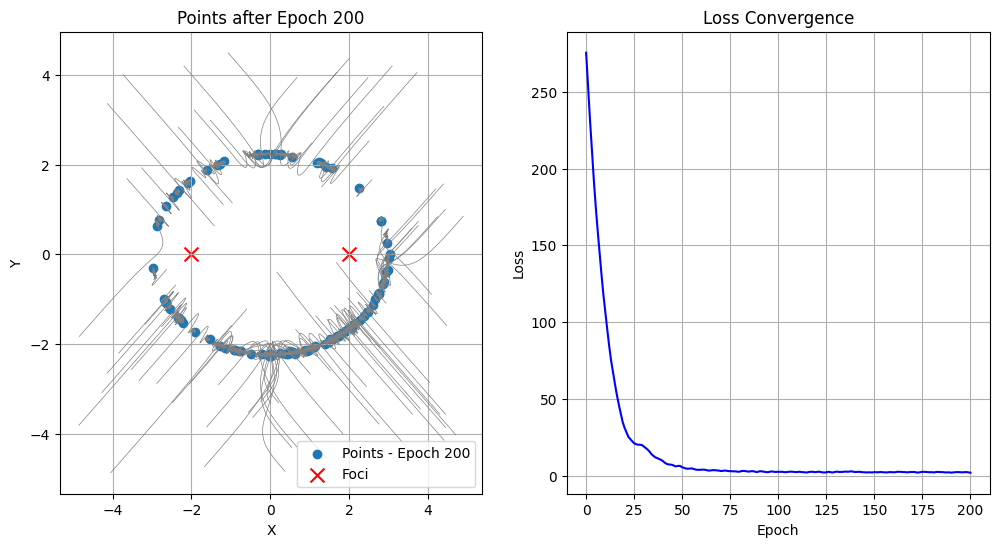

Epoch 200: Loss = 1.826775


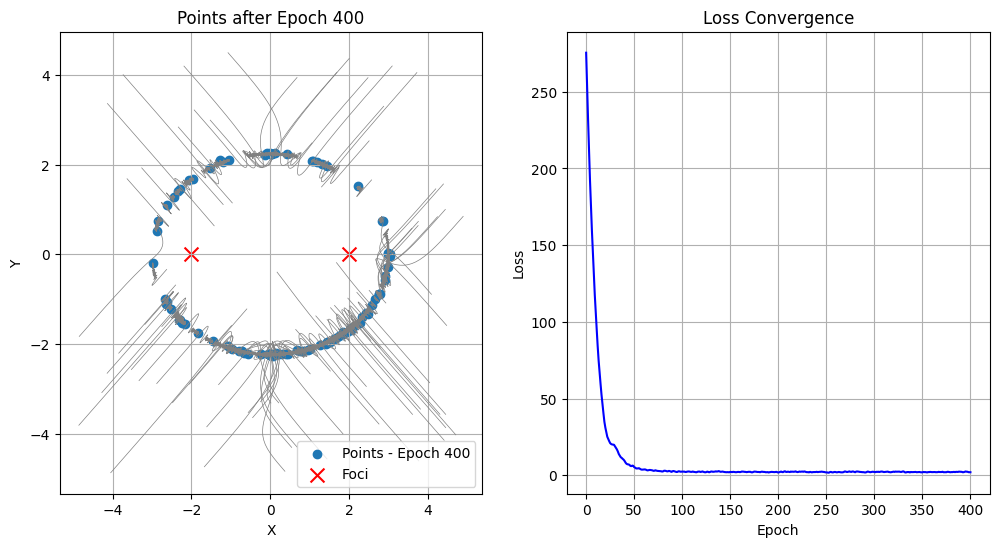

Epoch 400: Loss = 2.011140


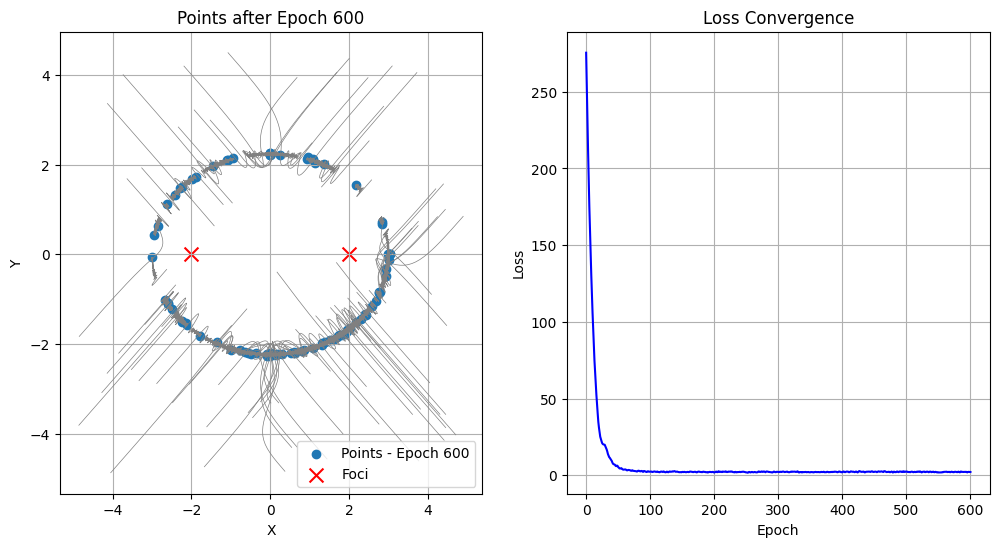

Epoch 600: Loss = 2.152333


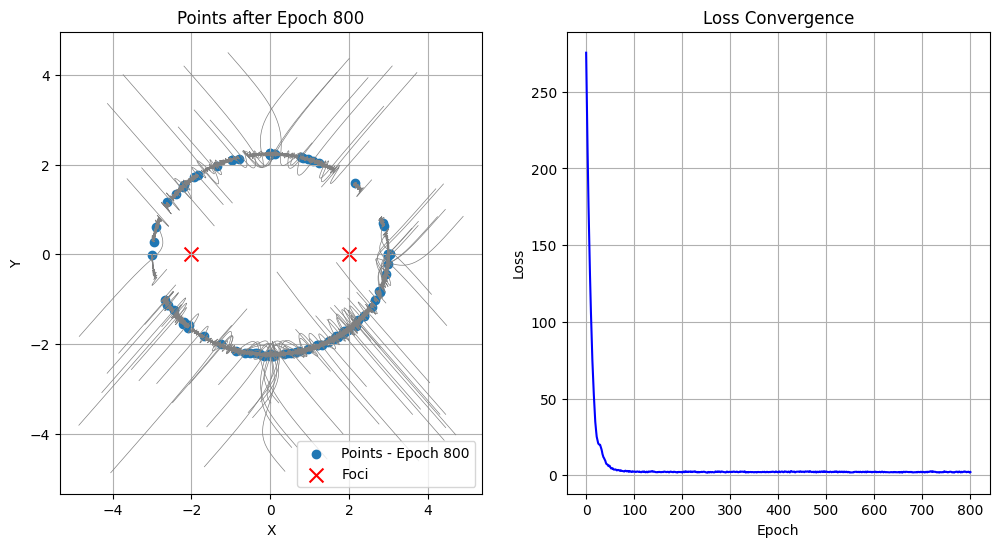

Epoch 800: Loss = 2.120120


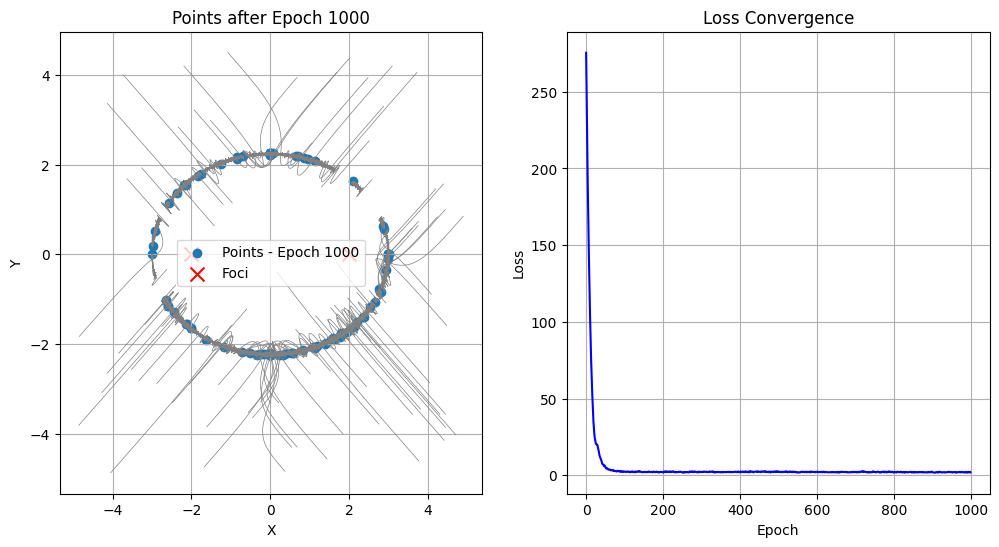

Elapsed time: 7.03 seconds


In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time

# Fix the random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define ellipse parameters
focus1 = torch.tensor([-2.0, 0.0])  # First focus
focus2 = torch.tensor([2.0, 0.0])   # Second focus
constant_sum = 6.0  # The sum of distances to the two foci

# Initialize random 2D points from uniform distribution
num_points = 100
points = torch.rand((num_points, 2)) * 10 - 5  # Uniformly distributed in [-5, 5]
points.requires_grad = True

# Reset trajectories
trajectories = [[] for _ in range(num_points)]
loss_history = []

# Define optimizer
optimizer = torch.optim.Adam([points], lr=0.1)

# Training loop parameters
num_epochs = 1000

# Plotting function
def plot_results(epoch, trajectories, loss_history=None):
    if loss_history is not None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(6, 6))
        axes = [axes]
    points_array = np.array([trajectories[i][-1] for i in range(num_points)])

    # Left plot: Scatter of points with trajectories
    axes[0].scatter(points_array[:, 0], points_array[:, 1], label=f'Points - Epoch {epoch}')
    f1 = focus1.detach().cpu().numpy()
    f2 = focus2.detach().cpu().numpy()
    axes[0].scatter([f1[0], f2[0]], [f1[1], f2[1]], color='red', marker='x', s=100, label='Foci')

    # Draw movement traces
    for i in range(num_points):
        trajectory = np.array(trajectories[i])
        axes[0].plot(trajectory[:, 0], trajectory[:, 1], color='gray', linestyle='-', linewidth=0.5)

    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[0].legend()
    axes[0].grid()

    if loss_history is not None:
        axes[0].set_title(f'Points after Epoch {epoch}')
        # Right plot: Loss history
        axes[1].plot(loss_history, color='blue')
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Loss")
        axes[1].set_title("Loss Convergence")
        axes[1].grid()
    else:
        axes[0].set_title(f'Points before Epoch {epoch}')

    plt.show()

# General training loop function
def run_program(loss_type):
    start_time = time.time()

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Compute distances to both foci
        dist1 = torch.norm(points - focus1, dim=1)
        dist2 = torch.norm(points - focus2, dim=1)
        errors = dist1 + dist2 - constant_sum

        # Choose loss based on selected type
        if loss_type == 'l0':
            loss = torch.sum(errors != 0)
        elif loss_type == 'l1':
            loss = torch.sum(torch.abs(errors))
        elif loss_type == 'linf':
            loss = torch.max(torch.abs(errors))
        else:
            raise ValueError(f"Unknown loss_type '{loss_type}'. Choose from 'l0', 'l1', 'linf'.")

        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        # Store current positions for tracking movement
        for i in range(num_points):
            trajectories[i].append(points[i].detach().cpu().clone().numpy())

        # Plot results every 200th epoch
        if epoch % 200 == 0:
            plot_results(epoch, trajectories, loss_history)
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

    # Final plot
    plot_results(num_epochs, trajectories, loss_history)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.2f} seconds")

# === Run the program here ===
loss_type = 'l1'  # Choose from 'l0', 'l1', 'linf'
run_program(loss_type)


In [16]:
run_program('l0')

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

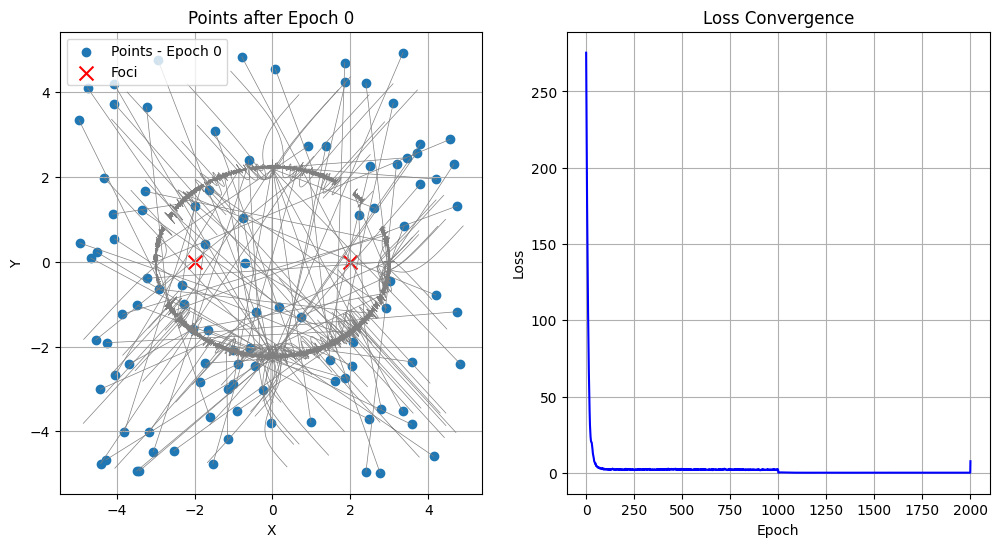

Epoch 0: Loss = 7.609116


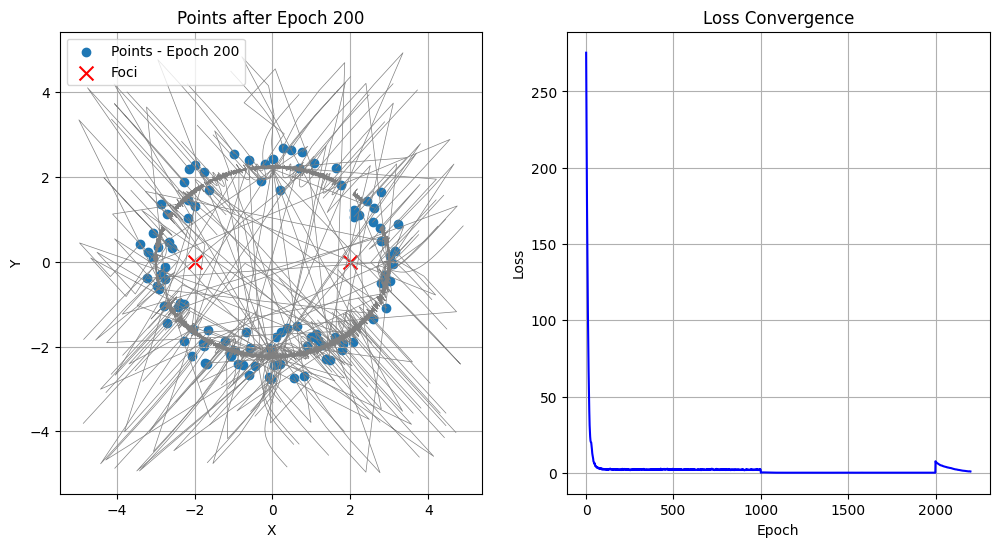

Epoch 200: Loss = 0.916277


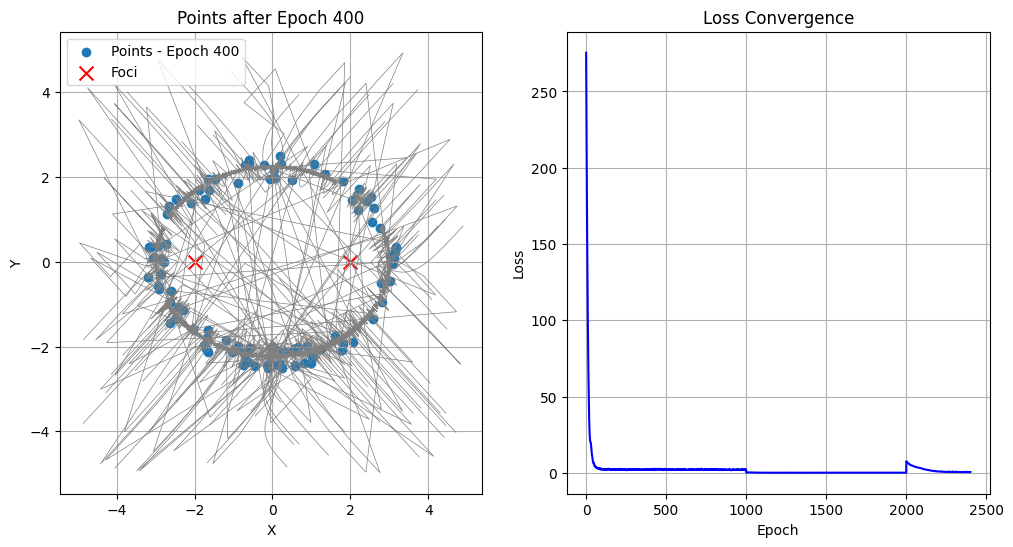

Epoch 400: Loss = 0.543033


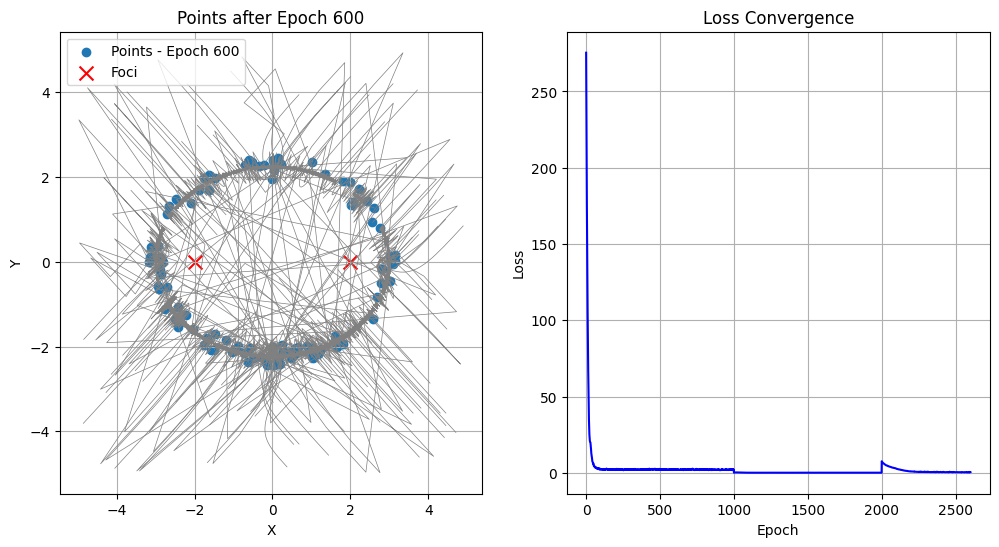

Epoch 600: Loss = 0.438895


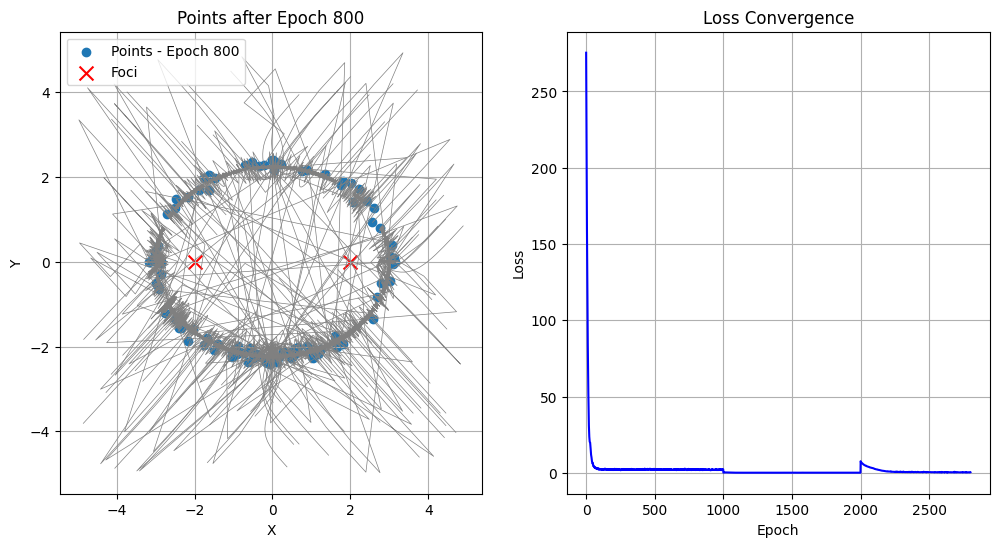

Epoch 800: Loss = 0.359158


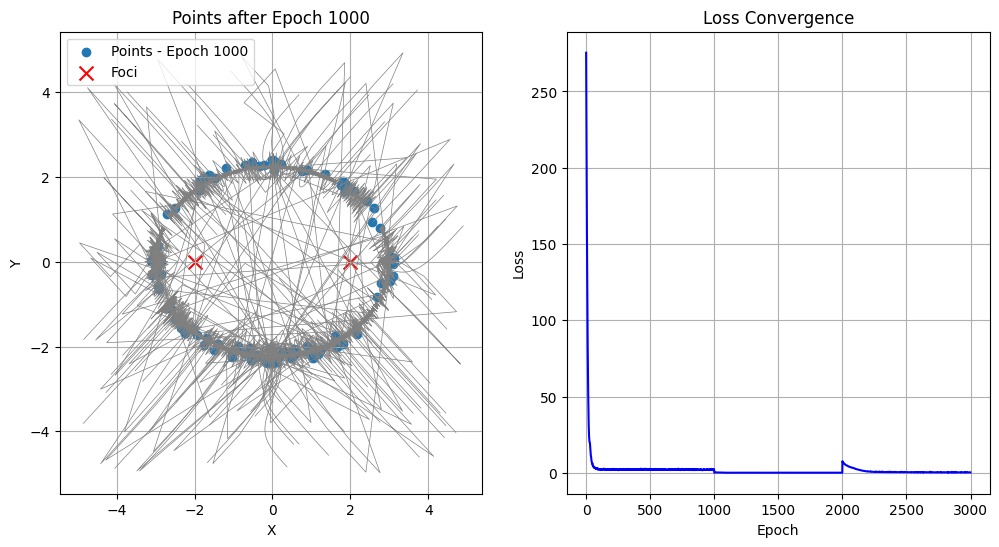

Elapsed time: 10.96 seconds


In [18]:
points = torch.rand((num_points, 2)) * 10 - 5  # Uniformly distributed in [-5, 5]
points.requires_grad = True
optimizer = torch.optim.Adam([points], lr=0.1)

run_program('linf')